<a href="https://colab.research.google.com/github/CeliaDiazSanchez/Sistemas__Control/blob/Practica_final/PF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**PROYECTO FINAL SISTEMAS DE CONTROL Inverted Pendulum Stabilization using PID Control [Proyecto Final]**

Celia Díaz Sánchez
Ingeniería Matemática 3B



## **Objetivo del proyecto**

El objetivo del proyecto final es diseñar y simular un sistema de control para estabilizar un péndulo invertido utilizando un controlador PID (Proporcional-Integral-Derivativo) en Python, mientras se exploran temas adicionales relacionados con el tema.

El problema que abordaremos es estabilizar un péndulo invertido utilizando un controlador PID. Comenzaremos definiendo el modelo del péndulo y luego diseñaremos un controlador PID utilizando diferentes métodos de sintonización, como Ziegler-Nichols o Cohen-Coon. Luego, analizaremos la estabilidad del sistema utilizando criterios como la ubicación de los polos del sistema o el criterio de Routh-Hurwitz. Finalmente, visualizaremos la respuesta del sistema en lazo cerrado, evaluando su estabilidad y desempeño.

## **Modelar el sistema**

El sistema de péndulo invertido puede modelarse utilizando las siguientes ecuaciones de
movimiento:

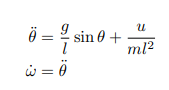

donde θ es el ángulo del péndulo, ω es la velocidad angular, g es la aceleración debida a la gravedad, l es la longitud del péndulo, m es la masa del péndulo y u es la entrada de control.
y u es la entrada de control.
Linealizando el modelo alrededor del punto de equilibrio (θ = 0, ω = 0) y
aplicando Laplace, obtenemos la función de transferencia:

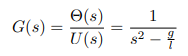

Cargamos la librerias necesariás y los datos para poder hacer el problema.

In [2]:
!pip install control

import numpy as np
import control as ctrl
g = 9.81 # gravity (m/s^2)
l = 1.0 # length of the pendulum (m)
m = 1.0 # mass of the pendulum (kg)
# Transfer function G(s) = 1 / (s^2 - g/l)
num = [1]
den = [1, 0, -g/l]


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 513.9/513.9 kB 5.5 MB/s eta 0:00:00


La función ctrl.TransferFunction(num, den) toma estos coeficientes y los utiliza para construir un objeto TransferFunction, que es una representación de la función de transferencia del sistema en el dominio de Laplace.

In [3]:
G = ctrl.TransferFunction(num, den)

## **Analizar la estabilidad del sistema inicial**


### **Mediante los polos**

Calculamos los polos de la función de la transformada, para ver si el sistema es estable o no.

In [4]:
poles = ctrl.poles(G)
print("Polos del sistema:", poles)

Polos del sistema: [-3.13209195+0.j  3.13209195+0.j]


Los polos son puntos en el plano complejo que determinan el comportamiento dinámico del sistema.

En este caso, los polos del sistema son
-3.13209195+0j y 3.13209195+0j, lo que indica que ambos son reales y no tienen una parte imaginaria (representada por
0j). Este sistema tiene dos polos en el eje real, lo que sugiere que es un sistema lineal, y que ambos polos tienen la misma parte real pero de signo opuesto.

Analizamos los polos, una de los polos tiene parte real negativa, lo que significa que uno está a la izquierda del eje imaginario y el otro a la derecha.

Como resultado, el sistema es inestable, ya que tiene al menos un polo con parte real positiva.

### **Método de Routh_Hurwitz**

La estabilidad del sistema de bucle abierto puede analizarse mediante Routh-Hurwitz
La ecuación característica del sistema es:

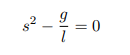

Para que el sistema sea estable, todas las raíces de la ecuación característica deben
tener partes reales negativas. El rango de parámetros del sistema para la estabilidad puede
determinarse en consecuencia.

Usamos el metodo de Routh_hurwitz para ver la estavilidad, y ver si nos da el mismo resultado que usando los polos.

El criterio de Routh-Hurwitz es un método utilizado para determinar la estabilidad de un sistema dinámico lineal a partir de los coeficientes de su ecuación característica. El criterio  evalua la ubicación de los polos del sistema en el plano complejo sin necesidad de calcularlos directamente.

El criterio de Routh-Hurwitz establece que un sistema es estable si todos los coeficientes de la primera columna del cuadro de Routh tienen el mismo signo. Si algunos de estos coeficientes tienen signo diferente, el sistema es inestable. Además, el número de raíces con parte real positiva es igual al número de cambios de signo en la primera columna del cuadro de Routh.

In [5]:
def routh_hurwitz(den):
    n = len(den)
    m = (n - 1) // 2 + 1
    rh_table = np.zeros((m, n))

    # Llenar la primera fila del cuadro de Routh
    rh_table[0, :n] = den[::2] if n % 2 == 0 else den

    # Llenar las filas restantes del cuadro de Routh
    for i in range(1, m):
        for j in range(n):
            if j >= 2 * i:
                rh_table[i, j] = rh_table[i - 1, j - 2] if rh_table[i - 1, j - 2] != 0 else 1e-12

    # Verificar la estabilidad
    sign_changes = np.sum(np.diff(np.sign(rh_table[:, 0])))

    if sign_changes == 0:
        print("El sistema es estable por el criterio de Routh-Hurwitz.")
    else:
        print("El sistema es inestable por el criterio de Routh-Hurwitz.")

    return rh_table

In [6]:
rh_table = routh_hurwitz(den)
print("Cuadro de Routh:")
print(rh_table)

El sistema es inestable por el criterio de Routh-Hurwitz.
Cuadro de Routh:
[[ 1.    0.   -9.81]
 [ 0.    0.    1.  ]]


Podemos ver con esa tabla solución de utilizar el método, al tener un cambio de signo en la primera columna, esto significa que el sistema es inertable
según el criterio de Routh-Hurwitz.

Concluimos que ambos métodos nos da el mimso resultado, no es establa.

## **Diseño de controladores PID y simulación**

El controlador PID puede diseñarse utilizando la siguiente ley de control:

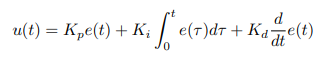

donde e(t) = θd -θ(t) es la señal de error, θd es el ángulo deseado (consigna), y
Kp, Ki
y Kd son las ganancias proporcional, integral y derivativa, respectivamente.
Las ganancias pueden determinarse mediante técnicas como la de Ziegler-Nichols o ajustándolas manualmente para alcanzar el valor deseado.
manualmente para lograr el rendimiento deseado.

Primer ejemplo con los valores dados en el enunciado de la práctica

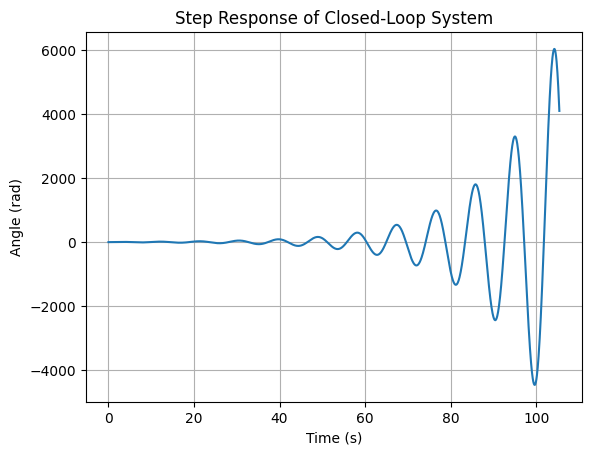

In [7]:
Kp = 10.0
Ki = 1.0
Kd = 2.0
# PID controller
controller = ctrl.TransferFunction([Kd, Kp, Ki], [1, 0])
import matplotlib.pyplot as plt
# Closed-loop system
closed_loop = ctrl.feedback(G * controller)
# Time response
t, y = ctrl.step_response(closed_loop)
# Plotting
plt.plot(t, y)
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.title('Step Response of Closed-Loop System')
plt.grid(True)
plt.show()

Podemos observar en la gráfica que no se llega a estavilizar con esos valores de las diferentes K.

In [8]:
# Obtener los polos del sistema en lazo cerrado
poles_closed_loop = ctrl.poles(closed_loop)
print("Polos del sistema:", poles_closed_loop)

Polos del sistema: [-2.1310412+0.j          0.0655206+0.68188066j  0.0655206-0.68188066j]


Vemos que como habíamos visto en la gráfica es sistema no es estable, ya que no todas las polos tiene su parte real negativa.

### **Ziegler_Nichols**

Como nos encontramos ante un sistema no estable usamos Ziegler_Nichols, para intentar estabilizarlo.

El método de Ziegler-Nichols es una técnica de sintonización de controladores PID ampliamente utilizada en ingeniería de control. Fue propuesto por John G. Ziegler y Nathaniel B. Nichols en 1942. El objetivo de este método es establecer los parámetros del controlador proporcional (KP), integral (KI) y derivativo (KD) para un sistema de control en lazo cerrado de manera rápida y eficiente.

Utiliza dos tipos de pruebas de respuesta del sistema: la prueba de respuesta al escalón y la prueba de respuesta a la onda cuadrada. A partir de los resultados de estas pruebas, se obtienen los parámetros del controlador PID de la siguiente manera:

Se compone de tres etapas principales para la sintonización de un controlador PID. En primer lugar, en la etapa del Controlador Proporcional (P), se incrementa gradualmente la ganancia proporcional
Kp hasta que el sistema se vuelva marginalmente estable, observando oscilaciones alrededor de un valor constante. El valor de Kp en el cual comienza esta oscilación se registra como Ku.

En la etapa siguiente, del Controlador Proporcional - Integral (PI), se calcula el periodo de oscilación del sistema
Pu a partir de Ku. Luego, se determinan los parámetros Kp y Ki utilizando diferentes reglas derivadas de Ziegler-Nichols, como la Regla de Cohen-Coon o la Regla de modificación de Ziegler-Nichols, adaptadas a las características específicas del sistema.

Finalmente, en la etapa del Controlador Proporcional - Integral - Derivativo (PID), se incorpora una acción derivativa al controlador PI para mejorar la respuesta transitoria y la estabilidad del sistema. Los parámetros Kd se calculan utilizando reglas derivadas de Ziegler-Nichols diseñadas para controladores PID, completando así la sintonización del controlador PID.

In [9]:
def ziegler_nichols(G):
    # Realizar un experimento con una entrada de paso unitario
    t, y = ctrl.step_response(G)

    # Calcular el tiempo de subida (tr)
    tr_index = np.argmax(y > 0.9 * y[-1])  # Índice del primer punto que alcanza el 90% del valor final
    tr = t[tr_index] - t[0]  # Tiempo transcurrido desde el inicio hasta el punto

    # Calcular el tiempo de establecimiento (ts)
    ts_index = np.where(np.abs(y - y[-1]) <= 0.02 * np.abs(y[-1]))[0][0]
    ts = t[ts_index] - t[0]  # Tiempo transcurrido desde el inicio hasta el punto

    # Calcular el máximo sobrepaso (Mp)
    Mp = np.max(y) - y[-1]
    # Si Mp es cero, asigna un valor predeterminado pequeño para evitar división por cero
    if Mp == 0:
        Mp = 0.01

    # Determinar los valores de los parámetros PID según las reglas de Ziegler-Nichols
    Kp = 0.6 / Mp
    Ki = 2 * Kp / (0.5 * tr)
    Kd = Kp * (0.125 * tr)

    # Devolver los valores calculados
    return Kp, Ki, Kd


Obtén los valores iniciales de los parámetros PID, mediante Ziegler_Nichols.

In [10]:
# Obtén los valores iniciales de los parámetros PID
Kp1, Ki1, Kd1 = ziegler_nichols(G)
if Kp1 is not None and Ki1 is not None and Kd1 is not None:
    print("Valores iniciales de los parámetros PID:")
    print("Kp:", Kp1)
    print("Ki:", Ki1)
    print("Kd:", Kd1)
else:
    print("Error: No se pudieron calcular los valores iniciales de los parámetros PID.")

Valores iniciales de los parámetros PID:
Kp: 60.0
Ki: 109.93042851762786
Kd: 16.373992390208517


Cremaos un controlador PID con los coeficientes especificados y representa su función de transferencia en el dominio de Laplace. Este controlador se puede utilizar luego en lazo cerrado con el sistema de planta para formar un sistema de control completo.

Posteriosmente usando el lazo cerrado lo graficamos.

In [11]:
# PID controller
controller1 = ctrl.TransferFunction([Kd1, Kp1, Ki1], [1, 0])

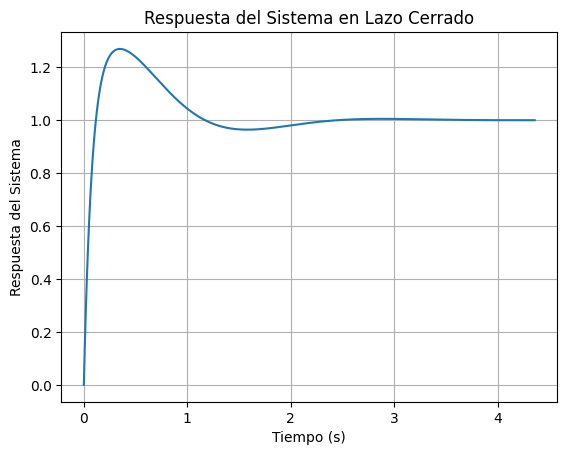

In [12]:
import matplotlib.pyplot as plt
# Sistema en lazo cerrado
closed_loop1 = ctrl.feedback(G * controller1)
# Simulación de la respuesta del sistema en lazo cerrado
t1, y1 = ctrl.step_response(closed_loop1)

# Verificar estabilidad: Observar si la respuesta es acotada y no crece indefinidamente
plt.plot(t1, y1)
plt.xlabel('Tiempo (s)')
plt.ylabel('Respuesta del Sistema')
plt.title('Respuesta del Sistema en Lazo Cerrado')
plt.grid(True)
plt.show()

En la gráfica obserbamos:
1. El sistema inicialmente se encuentra en el equilibrio (valor de salida 0).
2. Al aplicar el escalón de entrada, la respuesta del sistema comienza a aumentar.
3. La respuesta del sistema alcanza un máximo de 1.2 antes de comenzar a converger hacia el valor de estado estable.
3. Finalmente, el sistema alcanza un estado estable donde la respuesta se estabiliza en 1, lo que indica que el sistema ha alcanzado su nueva posición de equilibrio después de la perturbación inicial.

Podemos concluir que la respuesta del sistema es estable, ya que se estabiliza en un valor específico, 1 después de la transición inicial. Esto indica que el sistema ha alcanzado un equilibrio y su comportamiento es predecible y controlado usando el método de Ziegler_Nichols.

In [13]:
# Obtener los polos del sistema en lazo cerrado
polos1 = ctrl.poles(closed_loop1)
print("Polos del sistema:", polos1)

Polos del sistema: [-13.203261 +0.j          -1.5853657+2.41093788j  -1.5853657-2.41093788j]


Vemos que todos los polos tiene su parte real negativa, por lo tanto es estable como se ve en la gráfica, se ha estavilizado en 1.

### **Cohen Coon**

Usamos el método de Cohen Coon, para ver si se estaviliza de la misma forma que con el método anterior.

El método de Cohen-Coon es una técnica para ajustar los parámetros de un controlador PID. Se basa en realizar una prueba de respuesta al escalón para determinar dos parámetros clave del sistema: el tiempo de retardo (tau) y el coeficiente de tiempo integral (L). Luego, se calculan los parámetros \(K_p\) y \(K_i\) del controlador proporcional-integral (PI) utilizando fórmulas simples basadas en estos valores. Finalmente, la ganancia derivativa \(K_d\) se ajusta según necesidad, generalmente de forma manual o mediante otros métodos de sintonización. Este método es fácil de implementar y puede proporcionar una buena aproximación inicial de los parámetros del controlador PID.

In [14]:
def cohen_coon(G):
    # Paso 1: Sintonización del controlador proporcional (Kp)
    Kp = 0.6 / G.dcgain()

    # Paso 2: Sintonización del controlador integral (Ki)
    poles = ctrl.poles(G)
    tau = -1 / np.real(poles[0])  # Tiempo constante del proceso
    Ki = Kp / (0.5 * tau)

    # Paso 3: Sintonización del controlador derivativo (Kd)
    td = 0.5 * tau
    Kd = Kp * (0.125 * tau)

    return Kp, Ki, Kd

In [15]:
# Obtén los valores iniciales de los parámetros PID
Kp2, Ki2, Kd2 = cohen_coon(G)
if Kp2 is not None and Ki2 is not None and Kd2 is not None:
    print("Valores iniciales de los parámetros PID:")
    print("Kp:", Kp2)
    print("Ki:", Ki2)
    print("Kd:", Kd2)
else:
    print("Error: No se pudieron calcular los valores iniciales de los parámetros PID.")

Valores iniciales de los parámetros PID:
Kp: -5.886
Ki: -36.8709864668685
Kd: -0.2349068964504874


In [16]:
# PID controller
controller2 = ctrl.TransferFunction([Kd2, Kp2, Ki2], [1, 0])

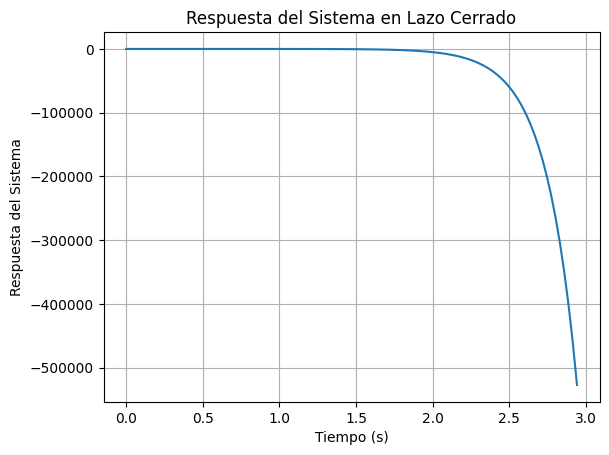

In [17]:
import matplotlib.pyplot as plt
# Sistema en lazo cerrado
closed_loop2 = ctrl.feedback(G * controller2)
# Simulación de la respuesta del sistema en lazo cerrado
t2, y2 = ctrl.step_response(closed_loop2)

# Verificar estabilidad: Observar si la respuesta es acotada y no crece indefinidamente
plt.plot(t2, y2)
plt.xlabel('Tiempo (s)')
plt.ylabel('Respuesta del Sistema')
plt.title('Respuesta del Sistema en Lazo Cerrado')
plt.grid(True)
plt.show()

Podemos observar en la gráfica que en vez de estavilizarse, ocurre todo lo contrario, empieza estable y finalmente cae en picado hasta en -infinito.

In [18]:
# Obtener los polos del sistema en lazo cerrado
polos2 = ctrl.poles(closed_loop2)
print("Poles of the system:", polos2)

Poles of the system: [ 4.93252093+0.j         -2.34880702+1.39935169j -2.34880702-1.39935169j]


Con los polos vemos que uno no tiene la parte real negativa, por lo tanto no es estable. Misma conclusión que sacamos antes con la gráfica.

## **Visualización**

Para terminar, visualizamos el sitemas estable conseguido con el método de Ziegler-Nichols.

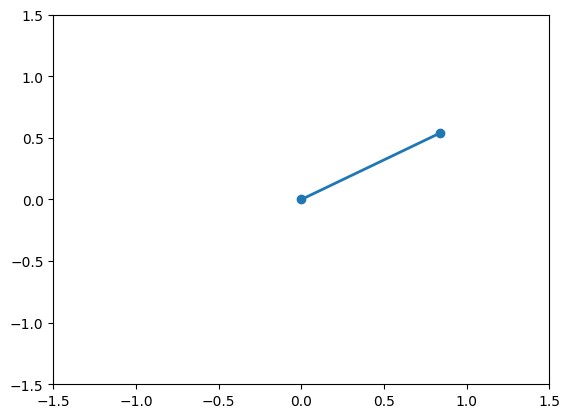

In [19]:
from matplotlib import animation, rc
from IPython.display import HTML

# Define la función de animación
def animate(i):
    line.set_data([0, np.sin(y1[i])], [0, np.cos(y1[i])])
    return line,

# Crea la figura y los ejes
fig, ax = plt.subplots()
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)

# Crea la línea para la animación
line, = ax.plot([], [], 'o-', lw=2)

# Crea la animación
ani = animation.FuncAnimation(fig, animate, frames=len(y1), interval=50, blit=True)

# Muestra la animación
HTML(ani.to_html5_video())

## **Conclusión**

En conclusión, este trabajo ha abordado diversas técnicas de diseño y análisis de sistemas de control utilizando Python como herramienta principal. Mediante la implementación de controladores PID utilizando métodos como Ziegler-Nichols y Cohen-Coon, así como el ajuste de respuesta en frecuencia, hemos demostrado la versatilidad y eficacia de estas técnicas en la sintonización de sistemas de control para alcanzar objetivos de rendimiento deseados. Además, hemos utilizado herramientas como la visualización de polos y la aplicación del criterio de Routh-Hurwitz para evaluar la estabilidad de los sistemas de control. Los resultados obtenidos han mostrado la capacidad de los controladores PID sintonizados para lograr estabilidad y mejorar el rendimiento del sistema. Este trabajo sienta las bases para investigaciones futuras en el campo de los sistemas de control, incluyendo la aplicación de técnicas más avanzadas y el análisis de sistemas más complejos.

## **Referencias**

[1] Pdf de las indicaciones para hacer la práctica

[2] Controlador PID - Control automático - Picuino. (s.f.). https://www.picuino.com/es/control-pid.html

[3] http://verona.fi-p.unam.mx/~lfridman/clases/modos/cap4.pdf



In [28]:
!git version
!git config --global user.email "celiadiazsanchez@gmail.com"
!git config --global user.name "Celia"
!git clone --branch  Practica_final https://github.com/CeliaDiazSanchez/Sistemas__Control.git
!ls /content/Sistemas__Control/
%cd Sistemas__Control

git version 2.34.1
fatal: destination path 'Sistemas__Control' already exists and is not an empty directory.
PF.ipynb  README.md
/content/Sistemas__Control


In [29]:
!jupyter nbconvert --to html PF

[NbConvertApp] Converting notebook PF.ipynb to html
[NbConvertApp] Writing 859211 bytes to PF.html
